# Assessing Vocal Measurements to Predict Parkinson’s Disease

Group 6 proposal: Naomi Choong, Yashas Ganesh Prasad, Braydon Newman, Marylyn Yuwono

# Introduction: 
Parkinson’s Disease (PD), a progressive neurodegenerative disorder impairing motor abilities, is characterized by tremors, stiffness, and slowed movements. Many individuals with PD also experience voice problems including abnormal voice quality, volume and pitch (Ma et al., 2020). Evidence shows vocal changes manifest during the prodromal phase of PD, prior to onset of clinical symptoms and diagnosis (Harel et al., 2004). This suggests that vocal measurements may be a potential biomarker to detect early stage PD. Early detection and treatment can slow disease progression and may help mitigate symptoms. 

To investigate potential vocal biomarkers of PD, we aim to answer the following question: **Can acoustic measurements of voice predict Parkinson’s disease based on voice recordings?**

We will analyze a dataset of various acoustic measurements from vocal recordings of 31 subjects. Data was collected by Little et al. (2009). An average of 6 recordings of sustained vowel phonation were taken for each subject.  Each row in the dataset corresponds to one voice recording from a subject.

Source: https://www.kaggle.com/datasets/gargmanas/parkinsonsdataset

## Variables
To examine the predictive potential of acoustic measurements, we will use the K-nearest neighbors classification algorithm. Variables were selected based on past literature, showing patients with PD had higher jitter, shimmer, and pitch variability, and reduced harmonics to noise ratio compared to healthy subjects (Jiménez-Jiménez et al., 1997; Ma et al., 2020). 


Variables used:
- `status` - health status of subject; Parkinson’s = 1, healthy =0
- `MDVP:Jitter (abs)` - absolute jitter in microseconds (variation in frequency)
- `Shimmer:DDA` - local shimmer in decibels (variation in amplitude)
- `PPE` - pitch period entropy (variation in pitch)
- `HNR` - harmonics-to-noise ratio (quantifies amount of additive noise in voice)


# Read and Tidy Data
... 


In [24]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)
install.packages("kknn")
library(kknn)

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [25]:
# reading dataset using URL from GitHub
set.seed(1234)

url <- "https://raw.githubusercontent.com/naomichoong/ds_project/main/parkinsons.csv"
parkinsons_data <- read_csv(url)
parkinsons_data

Rows: 195 Columns: 24
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): name
dbl (23): MDVP:Fo(Hz), MDVP:Fhi(Hz), MDVP:Flo(Hz), MDVP:Jitter(%), MDVP:Jitt...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


name,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,⋯,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
phon_R01_S01_1,119.992,157.302,74.997,0.00784,7e-05,0.00370,0.00554,0.01109,0.04374,⋯,0.06545,0.02211,21.033,1,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
phon_R01_S01_2,122.400,148.650,113.819,0.00968,8e-05,0.00465,0.00696,0.01394,0.06134,⋯,0.09403,0.01929,19.085,1,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
phon_R01_S01_3,116.682,131.111,111.555,0.01050,9e-05,0.00544,0.00781,0.01633,0.05233,⋯,0.08270,0.01309,20.651,1,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
phon_R01_S50_4,174.688,240.005,74.287,0.01360,8e-05,0.00624,0.00564,0.01873,0.02308,⋯,0.03804,0.10715,17.883,0,0.407567,0.655683,-6.787197,0.158453,2.679772,0.131728
phon_R01_S50_5,198.764,396.961,74.904,0.00740,4e-05,0.00370,0.00390,0.01109,0.02296,⋯,0.03794,0.07223,19.020,0,0.451221,0.643956,-6.744577,0.207454,2.138608,0.123306
phon_R01_S50_6,214.289,260.277,77.973,0.00567,3e-05,0.00295,0.00317,0.00885,0.01884,⋯,0.03078,0.04398,21.209,0,0.462803,0.664357,-5.724056,0.190667,2.555477,0.148569


In [26]:
# Tidying and modifying parkinsons dataset

parkinsons_data <- parkinsons_data |>
    select(status, "MDVP:Jitter(Abs)", "Shimmer:DDA", PPE, HNR) |>
    rename(jitter = "MDVP:Jitter(Abs)", shimmer = "Shimmer:DDA", ppe = PPE, hnr = HNR) |>
    mutate(status = as_factor(status)) |>
    mutate(status = fct_recode(status, "Parkinson's" = "1", "Healthy" = "0"))
parkinsons_data


status,jitter,shimmer,ppe,hnr
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
Parkinson's,7e-05,0.06545,0.284654,21.033
Parkinson's,8e-05,0.09403,0.368674,19.085
Parkinson's,9e-05,0.08270,0.332634,20.651
⋮,⋮,⋮,⋮,⋮
Healthy,8e-05,0.03804,0.131728,17.883
Healthy,4e-05,0.03794,0.123306,19.020
Healthy,3e-05,0.03078,0.148569,21.209


# Summarize data
... 



In [27]:
# Using intital split to create training and testing datasets 

parkinsons_split <- initial_split(parkinsons_data, prop = 0.75, strata = status)
parkinsons_train <- training(parkinsons_split)
parkinsons_test <- testing(parkinsons_split)


In [28]:
# summary statistics of training data

parkinsons_count <- parkinsons_train |>
    group_by(status) |>
    summarise(count = n())

parkinsons_count

parkinsons_mean <- parkinsons_train |>
    select(jitter, shimmer, ppe, hnr) |>
    map_df(mean)

parkinsons_mean

parkinsons_missing <- sum(is.na(parkinsons_train))
parkinsons_missing


status,count
<fct>,<int>
Healthy,36
Parkinson's,110


jitter,shimmer,ppe,hnr
<dbl>,<dbl>,<dbl>,<dbl>
4.618493e-05,0.04889753,0.2098519,21.65699


[1] 0

# Exploratory Data Visualization
...



`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 4 rows containing missing values (`geom_bar()`).”
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 4 rows containing missing values (`geom_bar()`).”


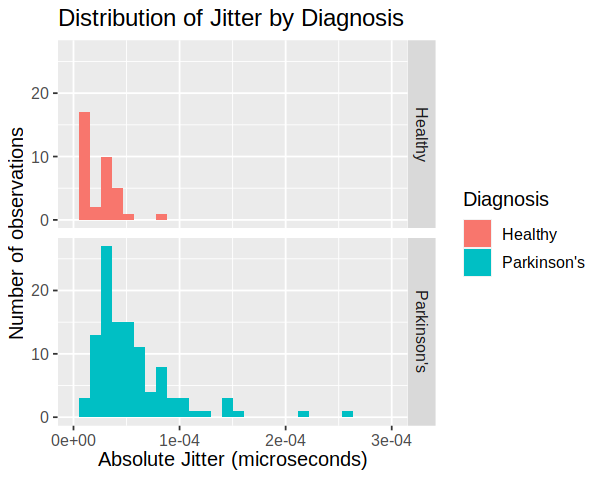

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 4 rows containing missing values (`geom_bar()`).”


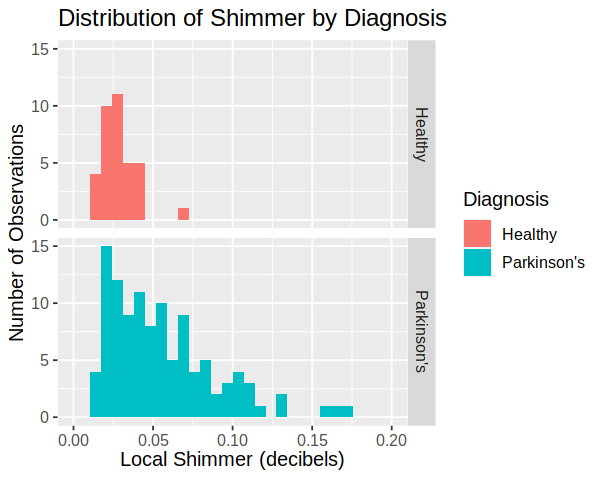

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 4 rows containing missing values (`geom_bar()`).”


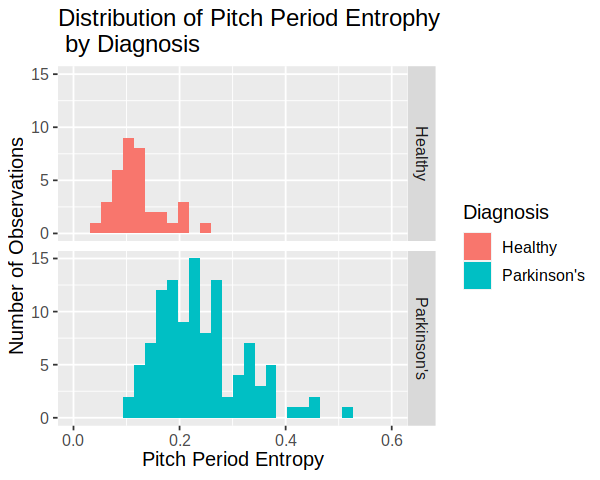

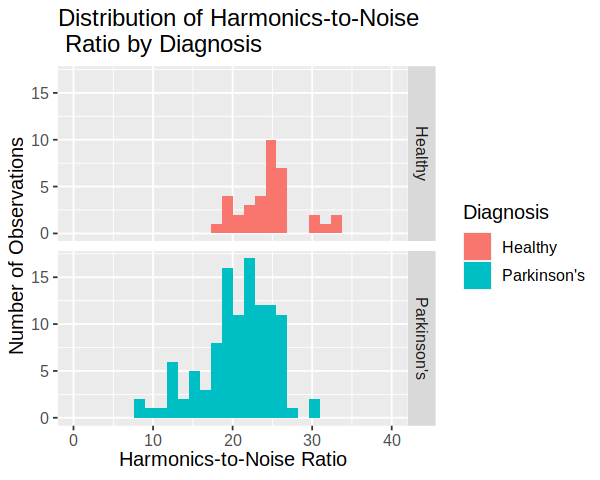

In [29]:
# preliminary data visualization - exploratory data analysis of training data

options(repr.plot.width = 5, repr.plot.height = 4)
jitter_plot <- parkinsons_train |>
    ggplot(aes(x = jitter, fill = status)) +
    geom_histogram() +
    facet_grid(rows = vars(status)) +
    labs(x = "Absolute Jitter (microseconds)",
         y = "Number of observations",
         fill = "Diagnosis") +
    scale_x_continuous(limits = c(0, 0.0003)) +
    ggtitle("Distribution of Jitter by Diagnosis") +
    theme(text = element_text(size = 12))

jitter_plot

shimmer_plot <- parkinsons_train |>
    ggplot(aes(x = shimmer, fill = status)) +
    geom_histogram() +
    facet_grid(rows = vars(status)) +
    labs(x = "Local Shimmer (decibels)",
         y = "Number of Observations",
         fill = "Diagnosis") +
    scale_x_continuous(limits = c(0, 0.20)) +
    ggtitle("Distribution of Shimmer by Diagnosis") +
    theme(text = element_text(size = 12))

shimmer_plot

ppe_plot <- parkinsons_train |>
    ggplot(aes(x = ppe, fill = status)) +
    geom_histogram() +
    facet_grid(rows = vars(status)) +
    labs(x = "Pitch Period Entropy",
         y = "Number of Observations",
         fill = "Diagnosis") +
        scale_x_continuous(limits = c(0, 0.6)) +
    ggtitle("Distribution of Pitch Period Entrophy \n by Diagnosis") +
    theme(text = element_text(size = 12))

ppe_plot

hnr_plot <- parkinsons_train |>
    ggplot(aes(x = hnr, fill = status)) +
    geom_histogram() +
    facet_grid(rows = vars(status)) +
    labs(x = "Harmonics-to-Noise Ratio",
         y = "Number of Observations",
         fill = "Diagnosis") +
    scale_x_continuous(limits = c(0, 40)) +
    ggtitle("Distribution of Harmonics-to-Noise \n Ratio by Diagnosis") +
    theme(text = element_text(size = 12))

hnr_plot

## Preliminary Data Analysis Results
...

# K-Nearest Neighbours Classification Analysis
To investigate our question, the dataset will be split into a training and testing set. The optimal k value will then be selected using a 5-fold cross validation on the training set. The k value with the highest accuracy estimate that does not decrease significantly when changing the k to a nearby value will be used. The final model will be built using the optimal k value and used to evaluate the accuracy of our classifier on the test set. By computing and evaluating metrics for our classification model, we will be able to examine whether acoustic measures of voice can predict Parkinson’s disease. 

A line plot showing the accuracy estimate against the number of nearest neighbors (k) will be used to visualize results. Each point represents the accuracy of the K-nearest neighbors algorithm at a specific value of k, which helps determine the optimal value of k for our classification model. The final stacked bar plot will represent the health status of the subject by the predicted diagnosis of the subjects to evaluate the strength of our classifier. 

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.8158621,5,0.03706856,Preprocessor1_Model01
3,accuracy,binary,0.8496552,5,0.02509435,Preprocessor1_Model02
5,accuracy,binary,0.8698851,5,0.02004882,Preprocessor1_Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
45,accuracy,binary,0.7878161,5,0.019613116,Preprocessor1_Model23
47,accuracy,binary,0.7740230,5,0.007926869,Preprocessor1_Model24
49,accuracy,binary,0.7604598,5,0.009517352,Preprocessor1_Model25


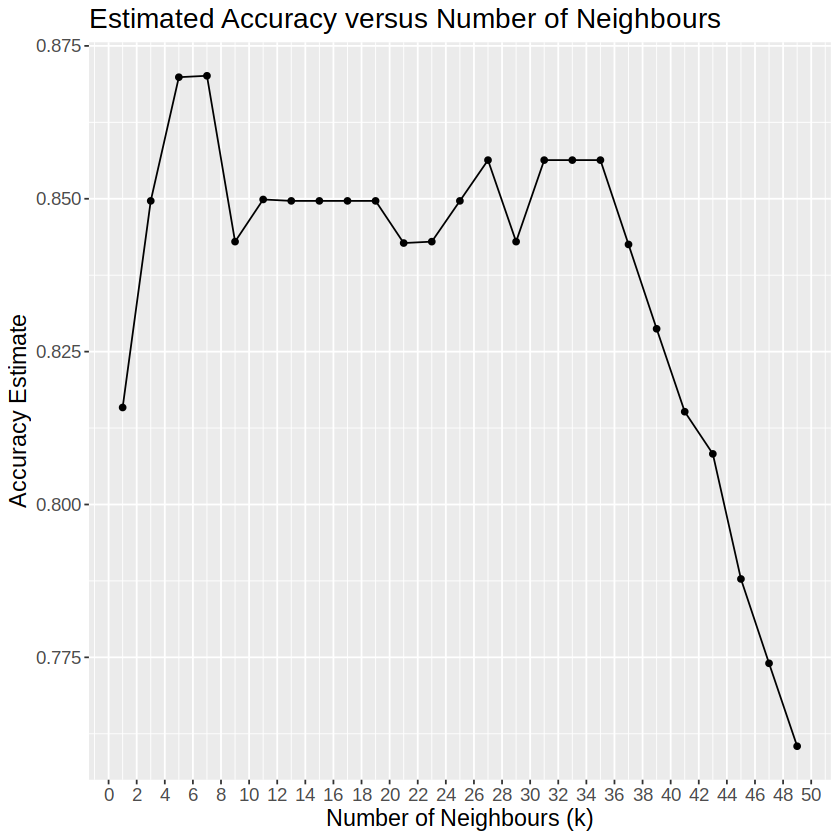

In [30]:
# K-nearest neighbours classification analysis
set.seed(1234)
options(repr.plot.height = 7, repr.plot.width = 7)

# Create recipe to standardize training data
parkinsons_recipe <- recipe(status ~., data = parkinsons_train) |>
    step_center(all_predictors()) |>
    step_scale(all_predictors())

# Create nearest_neighbor model specification with tuning on number of neighbours
parkinsons_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

# 5-fold cross-validation on training data
parkinsons_vfold <- vfold_cv(parkinsons_train, v = 5, strata = status)

# Create workflow with k ranging from 1 to 100 (by 5) and collect metrics
gridvals <- tibble(neighbors = seq(from = 1, to = 50, by = 2))

parkinsons_results <- workflow() |>
    add_recipe(parkinsons_recipe) |>
    add_model(parkinsons_spec) |>
    tune_grid(resamples = parkinsons_vfold, grid = gridvals) |>
    collect_metrics()|>
    filter(.metric == "accuracy")
parkinsons_results

# plot k (number of neighbours) vs accuracy to choose best k
parkinsons_k_plot <- parkinsons_results |>
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    xlab("Number of Neighbours (k)") +
    ylab("Accuracy Estimate") +
    scale_x_continuous(breaks = seq(0, 50, by = 2)) +
    ggtitle("Estimated Accuracy versus Number of Neighbours") +
    theme(text = element_text(size = 14))

parkinsons_k_plot


In [33]:
# knn classification final model with optimal k 

parkinsons_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 7) |>
    set_engine("kknn") |>
    set_mode("classification")

parkinsons_fit <- workflow() |>
    add_recipe(parkinsons_recipe) |>
    add_model(parkinsons_spec) |>
    fit(data = parkinsons_train)

# use final model to predict on test data
parkinsons_predictions <- predict(parkinsons_fit, parkinsons_test) |>
    bind_cols(parkinsons_test)

parkinsons_metrics <- parkinsons_predictions |>
    metrics(truth = status, estimate = .pred_class) |>
    filter(.metric == "accuracy")
parkinsons_metrics

parkinsons_conf_matrix <- parkinsons_predictions |>
    conf_mat(truth = status, estimate = .pred_class)
parkinsons_conf_matrix

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.877551


             Truth
Prediction    Healthy Parkinson's
  Healthy           8           2
  Parkinson's       4          35

# Final Visualization
.Naomi

Joining with `by = join_by(status, jitter, shimmer, ppe, hnr)`
`summarise()` has grouped output by 'status'. You can override using the
`.groups` argument.


status,.pred_class,n
<fct>,<fct>,<int>
Healthy,Healthy,8
Healthy,Parkinson's,4
Parkinson's,Healthy,2
Parkinson's,Parkinson's,35


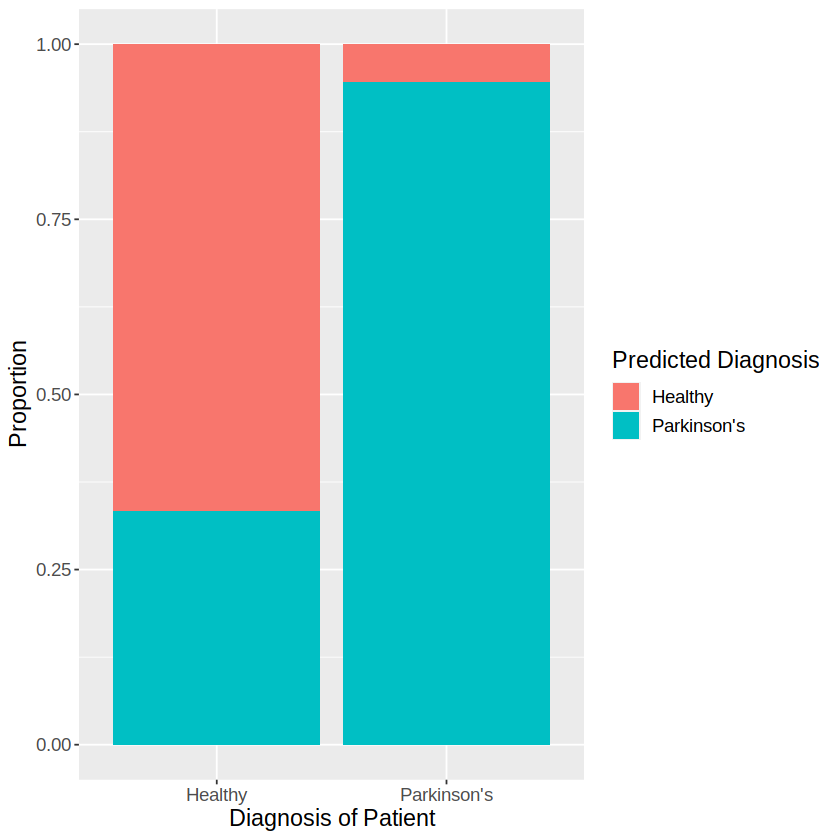

In [36]:
# Final Stacked Bar Graph  
predictions_count <- parkinsons_predictions |>
    semi_join(parkinsons_test) |>
    group_by(status, .pred_class) |>
    summarize(n=n())

predictions_count


parkinsons_final_graph <- predictions_count |>
   ggplot(aes(x = status, y = n, fill = .pred_class)) +
    geom_bar(position = "fill", stat = "identity") +
    labs(x = "Diagnosis of Patient", y = "Proportion", fill = "Predicted Diagnosis") +
    theme(text = element_text(size = 14))
parkinsons_final_graph
    

# Discussion

It is expected that the acoustic features will demonstrate significant differences between individuals with PD and healthy patients, providing a basis for classification which can be used for early detection of PD.

If our classification model shows good accuracy, voice analysis could become an early diagnosis screening tool and help initiate earlier treatment, potentially slowing disease progression. In the larger scope of medicine, the study’s findings can generate awareness regarding the utility of acoustic measurements for neurological and neurodegenerative disorders.

Future research could focus on larger, more diverse, patient populations. The study further provokes interest in other diagnostic tools and acoustic biomarkers that could be included to create more comprehensive diagnostic models. 

## References

Harel, B., Cannizzaro, M., & Snyder, P. J. (2004). Variability in fundamental frequency during speech in prodromal and incipient parkinson's disease: A longitudinal case study. Brain and Cognition, 56(1), 24-29. https://doi.org/10.1016/j.bandc.2004.05.002

Jiménez-Jiménez, F. J., Gamboa, J., Nieto, A., Guerrero, J., Orti-Pareja, M., Molina, J. A., García-Albea, E., & Cobeta, I. (1997). Acoustic voice analysis in untreated patients with parkinson's disease. Parkinsonism & Related Disorders, 3(2), 111-116. https://doi.org/10.1016/S1353-8020(97)00007-2

Little, M. A., McSharry, P. E., Hunter, E. J., Spielman, J., & Ramig, L. O. (2009). Suitability of dysphonia measurements for telemonitoring of parkinson's disease. IEEE Transactions on Biomedical Engineering, 56(4), 1015-1022. https://doi.org/10.1109/TBME.2008.2005954

Ma, A., Lau, K. K., & Thyagarajan, D. (2020). Voice changes in Parkinson’s disease: What are they telling us?. Journal of Clinical Neuroscience, 72, 1-7. https://doi.org/10.1016/j.jocn.2019.12.029